In [3]:
#импорты
import os
import torch
import torchvision
from torchvision import transforms
# from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.chdir(r'C:\Users\Mikhail\VS Code Projects\AI shit')

In [14]:
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import os


class RestoreDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        # self.classes = sorted(os.listdir(os.path.join(self.root_dir, 'restore_dataset')))
        self.file_paths = self._load_data(train)
        # if self.train:
        #     self.file_paths, self.labels = self._load_data(train)
        # else:
        #     self.file_paths = self._load_data(train)
        
        self.data = []
        for file_path in self.file_paths:
            self.data.append(Image.open(file_path))
        
        
    def __len__(self):
        return len(self.file_paths)

    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        sample = Image.open(file_path)
        if self.transform:
            sample = self.transform(sample)
        
        if self.train:
            # label = self.labels[idx]
            return sample
        else:
            return sample
    
    def _load_data(self, train):
        file_paths = []
        
        if self.train:
            # labels_dict = {self.classes[i]: i for i in range(42)}
            path = os.path.join(self.root_dir, 'restore_dataset', 'train')
            
            # labels = []
            
            for filename in sorted(os.listdir(path)):
                file_path = os.path.join(path, filename)
                file_paths.append(file_path)
                

            # for class_name in self.classes:
            #     folder_path = os.path.join(path, class_name)
            #     #print(f'Loading {label} images')
            #     for filename in sorted(os.listdir(folder_path)):
            #         file_path = os.path.join(folder_path, filename)
            #         file_paths.append(file_path)
            #         # labels.append(labels_dict[class_name])
                    #print('=', end='')
                #print(']')
            
            return file_paths #, labels
        else:
            for filename in os.listdir(os.path.join(self.root_dir, 'restore_dataset', 'test')):
                file_path = os.path.join(os.path.join(self.root_dir, 'restore_dataset', 'test'), filename)
                file_paths.append(file_path)
                #print(file_path)
            
            return file_paths
         

In [40]:
import torch 
import torchvision.transforms as v2 
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

transform = v2.Compose([
    v2.ToTensor(), 
    v2.Resize((100, 100), antialias=True),
    ])
# v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

trainset = RestoreDataset(root_dir='data', train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = RestoreDataset(root_dir='data', train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [64]:
def noisify(data, num=10):
    noisy = data
    dots_coord = np.random.random_integers(0, data.shape[1]-1, size=(num, 2))
    for x, y in dots_coord:
        noisy[0][x][y] = 0
        noisy[1][x][y] = 0
        noisy[2][x][y] = 0
    return noisy

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_14048\2752746718.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 99 + 1) instead
  dots_coord = np.random.random_integers(0, data.shape[1]-1, size=(num, 2))


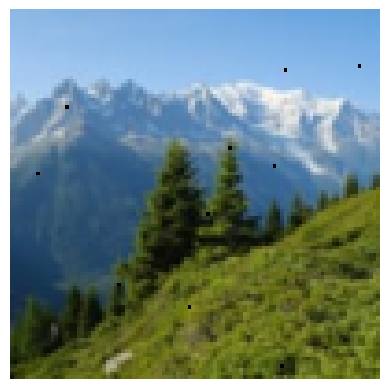

In [66]:
i = 0
img, data = trainloader.dataset.data[i], trainloader.dataset[i]
# out = img.resize(100, 100, 3)
noisy = noisify(data)
plt.axis('off')
plt.imshow(data.permute(1, 2, 0))
plt.imshow(noisy.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26375675..0.27375263].


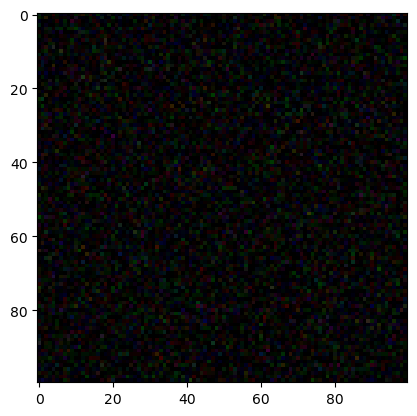

In [76]:
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape

        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.shape[0]*self.shape[1]*3, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=16, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.shape[0]*self.shape[1]*3)
        )

    def forward(self, x):
        x = x.view(-1, self.shape[0]*self.shape[1]*3)
        latent_code = self.encoder(x.float())
        reconstruction = self.decoder(latent_code.float())
        return reconstruction, latent_code

AE = Autoencoder((100, 100))
reconstruction, latent_code = AE(data)
plt.imshow(reconstruction.detach().view(3, 100, 100).permute(1, 2, 0))
plt.show()

In [ ]:
from tqdm import tqdm
import torch.optim as optim

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = nn.MSELoss()

autoencoder = Autoencoder((100, 100)).to(device)

optimizer = optim.Adam(autoencoder.parameters())

train_loss = []

epochs = 10

for epoch in tqdm(range(epochs)):
    autoencoder.train()
    train_loss_per_epoch = []
    for batch in trainloader:
        optimizer.zero_grad()
        reconstruction, latent_code = autoencoder(batch.float().to(device))
        loss = criterion(batch.float().view(-1, 100*100*3).to(device), reconstruction)
        loss.backward()
        optimizer.step()
        train_loss_per_epoch.append(loss.item())
    train_loss.append(np.mean(train_loss_per_epoch))

In [ ]:
plt.plot(np.arange(len(train_loss)), train_loss, label='Train')